In [1]:
from src import functions as fncs
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.patches as patches
from matplotlib import pyplot as plt

<h3>Area Bronowice</h3>

In [2]:
# pickup points Skotniki
p_points = gpd.read_file('data/area_bronowice/Lajkobus_miejsca_odbioru.shp')

In [3]:
p_points

,typ_miejsc,nazwa_miej,uwagi,geometry
0,miejsce_odbioru,Katowicka 1,None,POINT (2213317.694 6460918.400)
1,miejsce_odbioru,Odkrywców 1,None,POINT (2213423.196 6461226.062)
2,miejsce_odbioru,W. Żeleńskiego 1,None,POINT (2212585.525 6462368.226)
3,miejsce_odbioru,W. Żeleńskiego 2,None,POINT (2212597.866 6462373.974)
4,miejsce_odbioru,W. Żeleńskiego 3,None,POINT (2212482.857 6462075.076)
...,...,...,...,...
95,miejsce_odbioru,KMK Pasternik 02,None,POINT (2211718.277 6463378.573)
96,miejsce_oczekiwania,Ojcowska 5,None,POINT (2212924.620 6464820.891)
97,miejsce_oczekiwania,Pasternik 2,None,POINT (2212384.320 6462837.240)
98,miejsce_oczekiwania,Tetmajera 8,None,POINT (2212587.587 6461443.587)


In [4]:
# pickup point type
p_points['typ_miejsc'].value_counts()

typ_miejsc
miejsce_odbioru                95
miejsce_oczekiwania             4
miejsce_oczekiwania_odbioru     1
Name: count, dtype: int64

In [5]:
# change coordinate reference system (CRS) to EPSG:4326
p_points = p_points.to_crs(4326)

In [6]:
# form tuples with pickup point coordinates to calculate shortest distances
pickups = [(p[1]['x'], p[1]['y'], p[0]) for p in p_points['geometry'].get_coordinates().iterrows()]
# pickups[:5]

In [7]:
# read data for area Skotniki
area = gpd.read_file('data/area_bronowice/obszary_usługi.shp')
area

,nazwa,geometry
0,Bronowice Wielkie,"POLYGON ((2212814.728 6460634.972, 2213108.486..."


In [8]:
# change coordinate reference system (CRS) to EPSG:4326
area = area.to_crs(4326)
area

,nazwa,geometry
0,Bronowice Wielkie,"POLYGON ((19.87805 50.08284, 19.88069 50.08294..."


In [9]:
# read demographic of the city
addr_points = pd.read_csv('data/krk_demographic.csv', index_col=0)
addr_points = addr_points.rename(columns={"adr_pelny": "address", "ogolem": "total" })
addr_points

,x,y,address,total
FID,,,,
0,19.996604,50.086510,STANISŁAWA SKARŻYŃSKIEGO 9,975
1,20.014369,50.083876,OSIEDLE KOŚCIUSZKOWSKIE 6,955
2,19.997005,50.085446,STANISŁAWA SKARŻYŃSKIEGO 5,832
3,20.021469,50.086969,OSIEDLE KAZIMIERZOWSKIE 29,785
4,19.996731,50.084792,STANISŁAWA SKARŻYŃSKIEGO 3,775
...,...,...,...,...
47705,19.978465,50.072244,OSTATNIA 27,1
47706,19.954666,50.057313,KAROLA CHODKIEWICZA 10C,1
47707,19.879556,50.085813,WŁODZIMIERZA TETMAJERA 17A,1


In [10]:
# filter address points locating inside the Bronowice area
addr_points = addr_points.copy()
addr_points['inside_area'] = addr_points.apply(lambda row: 
                            area.geometry[0].contains(Point(row['x'], row['y'])), axis=1)
addr_points = addr_points[addr_points['inside_area']].reset_index(drop=True)
addr_points

,x,y,address,total,inside_area
0,19.885622,50.084549,WIZJONERÓW 2,233,True
1,19.886570,50.085111,WIZJONERÓW 7,196,True
2,19.885837,50.085314,WIZJONERÓW 4,174,True
3,19.886354,50.084393,WIZJONERÓW 5,89,True
4,19.887202,50.084495,KOMPOZYTORÓW 3,74,True
...,...,...,...,...,...
1222,19.889906,50.087955,ELIASZA RADZIKOWSKIEGO 152,1,True
1223,19.886080,50.094938,SOSNOWIECKA 19B,1,True
1224,19.888753,50.100075,STELMACHÓW 281A,1,True
1225,19.887916,50.082315,JABŁONKOWSKA 1,1,True


In [11]:
sum(addr_points.total)

8390

In [12]:
# calculate closest distance between the address point and the pickup point
closest_distance = lambda point: min([fncs.haversine(point, pickup)
                                        for pickup in pickups])
# find the closest pickup point
closest = lambda point: p_points.iloc[min([(fncs.haversine(point, pickup), pickup)
                                        for pickup in pickups])[1][2], :]

In [13]:
# test
closest((addr_points.loc[0, :].x, addr_points.loc[0, :].y)),\
      closest_distance((addr_points.loc[0, :].x, addr_points.loc[0, :].y))

(typ_miejsc                                 miejsce_odbioru
 nazwa_miej                                    Wizjonerów 2
 uwagi                                                 None
 geometry      POINT (19.886152696373927 50.08481647264796)
 Name: 90, dtype: object,
 0.0653051353890867)

In [14]:
closest_pickups = addr_points.apply(lambda row: closest((row.x, row.y)), axis=1)
closest_pickups

,typ_miejsc,nazwa_miej,uwagi,geometry
0,miejsce_odbioru,Wizjonerów 2,None,POINT (19.886152696373927 50.08481647264796)
1,miejsce_odbioru,Wizjonerów 3,None,POINT (19.886293882365464 50.08488397028969)
2,miejsce_odbioru,Wizjonerów 2,None,POINT (19.886152696373927 50.08481647264796)
3,miejsce_odbioru,Wizjonerów 2,None,POINT (19.886152696373927 50.08481647264796)
4,miejsce_odbioru,Wizjonerów 3,None,POINT (19.886293882365464 50.08488397028969)
...,...,...,...,...
1222,miejsce_odbioru,KMK Rondo Ofiar Katynia 02,None,POINT (19.890812655552455 50.08768716868892)
1223,miejsce_odbioru,Sosnowiecka 1,None,POINT (19.88628419836877 50.094356097213556)
1224,miejsce_odbioru,Jasnogórska 3,None,POINT (19.88819443855419 50.10142824766919)
1225,miejsce_odbioru,KMK Bronowice SKA 05,None,POINT (19.888531169146084 50.081751377069814)


In [15]:
addr_points['pickup_name'], addr_points['geometry'] = closest_pickups['nazwa_miej'], closest_pickups['geometry']
addr_points.drop('inside_area', axis=1, inplace=True)

In [16]:
addr_points['distance'] = addr_points.apply(lambda row: closest_distance((row.x, row.y)), axis=1)
addr_points.head(3)

,x,y,address,total,pickup_name,geometry,distance
0,19.885622,50.084549,WIZJONERÓW 2,233,Wizjonerów 2,POINT (19.886152696373927 50.08481647264796),0.065305
1,19.886570,50.085111,WIZJONERÓW 7,196,Wizjonerów 3,POINT (19.886293882365464 50.08488397028969),0.038854
2,19.885837,50.085314,WIZJONERÓW 4,174,Wizjonerów 2,POINT (19.886152696373927 50.08481647264796),0.062802


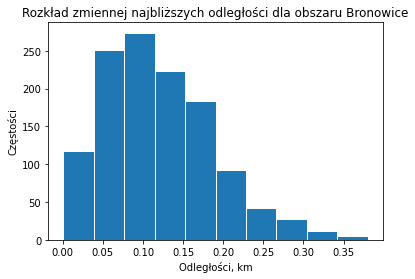

In [18]:
dists = addr_points['distance']
plt.hist(dists, edgecolor='white', bins=10)
# plt.title('Closest distances distribution')
plt.title('Rozkład zmiennej najbliższych odległości dla obszaru Bronowice')
plt.xlabel('Odległości, km')
plt.ylabel('Częstości')
# plt.savefig('results/images/bronowice_dist_distrib_pl.png', dpi=100)
plt.show()

In [19]:
dists = np.array(dists)
print('statystyki dla obszaru Bronowice:', '\nmean:', round(dists.mean(), 3), '\nstandard deviation:', round(dists.std(), 3),\
      '\nmin:', round(dists.min(), 3), 'max:', round(dists.max(), 3))

statystyki dla obszaru Bronowice: 
mean: 0.121 
standard deviation: 0.068 
min: 0.001 max: 0.38


In [20]:
# Area production
pSUM = pd.read_csv('input/demand_SUM(B).csv', index_col=0)
pSUM.head(3)

,origin_x,origin_y,destination_x,destination_y,treq,index,hub,ttrav,tarr,u,ttrav_sh,tarr_sh,u_sh,u_PT_OD,u_PT_HD_ASC,u_SUM_OD,p_SUM,r
0,19.884435,50.084156,19.885469,50.097415,2024-03-28 07:59:21,0,1786358199,46,2024-03-28 08:00:07,0.5750,46.0,2024-03-28 08:00:07,0.575000,11.037078,6.783269,9.939046,0.749891,1
6,19.889108,50.095237,19.959839,50.010086,2024-03-28 07:46:34,6,1786358199,283,2024-03-28 07:51:17,3.5435,283.0,2024-03-28 07:51:17,3.530250,21.637477,15.553896,21.664923,0.493139,1
9,19.872702,50.100578,19.916133,50.055493,2024-03-28 07:50:36,9,1786358199,408,2024-03-28 07:57:24,5.1030,422.0,2024-03-28 07:57:38,4.980675,22.378922,11.060417,18.621870,0.977180,1


In [21]:
exmas_addr = addr_points.iloc[addr_points.index.isin(pSUM['index'])]
exmas_addr.head(3)

,x,y,address,total,pickup_name,geometry,distance
0,19.885622,50.084549,WIZJONERÓW 2,233,Wizjonerów 2,POINT (19.886152696373927 50.08481647264796),0.065305
6,19.885505,50.083949,NAUKOWCÓW 1,52,Wizjonerów 2,POINT (19.886152696373927 50.08481647264796),0.115854
9,19.876145,50.092648,WŁADYSŁAWA ŻELEŃSKIEGO 84,49,W. Żeleńskiego 2,POINT (19.876104807041624 50.0928649495862),0.023075


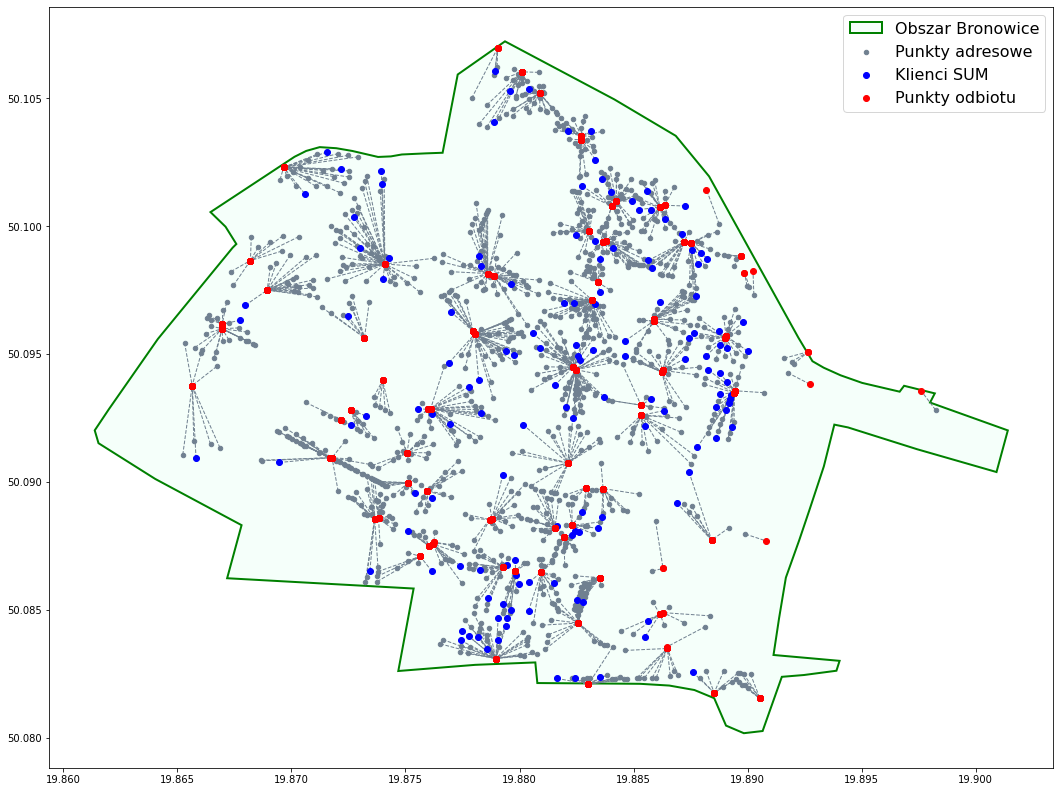

In [22]:
p_xs = [addr_points['geometry'][i].x for i in range(len(addr_points))]
p_ys = [addr_points['geometry'][i].y for i in range(len(addr_points))]

# exmas_xs = [exmas_addr['x'][i] for i in exmas_addr.index]
# exmas_ys = [exmas_addr['y'][i] for i in exmas_addr.index]

fig, ax = plt.subplots(figsize=(18, 14))

# polygon_patch = patches.Polygon(area.geometry[0].exterior.coords, closed=True, \
#                                 fill=False, edgecolor='green', linewidth=2, label='Skotniki Area')
polygon_patch = patches.Polygon(area.geometry[0].exterior.coords, closed=True, \
                                facecolor='mintcream', fill=True, edgecolor='green', linewidth=2, label='Obszar Bronowice')
ax.add_patch(polygon_patch)

# connections
for i in range(len(addr_points)):
    ax.plot([addr_points.loc[i, 'x'], addr_points['geometry'][i].x],
            [addr_points.loc[i, 'y'], addr_points['geometry'][i].y], 'k--', color='slategray', zorder=1, linewidth=1)
# address points
# ax.scatter(addr_points['x'], addr_points['y'], color='blue', label='Address Points')
ax.scatter(addr_points['x'], addr_points['y'], color='slategray', zorder=2, label='Punkty adresowe', s=20)
# address points that use SUM
ax.scatter(exmas_addr['x'], exmas_addr['y'], color='blue', zorder=3, label='Klienci SUM')
# pickup points
# ax.scatter(p_xs, p_ys, color='red', label='Pickup Points')
ax.scatter(p_xs, p_ys, color='red', zorder=4, label='Punkty odbiotu')

ax.legend(fontsize=16)
# ax.set_xlabel('X Coordinate', fontsize=16)
# ax.set_ylabel('Y Coordinate', fontsize=16)
# ax.set_title('Address Points and Closest Pickup Points', fontsize=20)
# ax.set_xlabel('Y', fontsize=16)
# ax.set_ylabel('X', fontsize=16)
# ax.set_title('Punkty adresowe i najbliższe punkty odbioru obszaru Bronowice', fontsize=20)
# plt.savefig('results/images/bronowice_shortest_dist_pl.png', dpi=100)

plt.show()